# Predicting hourly energy consumption
Dayton hourly power consumption data acquired from https://www.kaggle.com/robikscube/hourly-energy-consumption?select=DAYTON_hourly.csv  
Weather data acquired from https://www.ncdc.noaa.gov/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

In [2]:
mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
dayton = pd.read_csv('./DAYTON_hourly.csv', parse_dates=['Datetime'], date_parser=mydateparser)
dayton.columns = ['datetime', 'consumption']

In [3]:
dayton.shape

(121275, 2)

In [4]:
dayton.sample(10)

,datetime,consumption
42724,2009-05-18 15:00:00,1905.0
73716,2013-11-03 08:00:00,1563.0
69185,2012-05-10 11:00:00,1936.0
105148,2016-04-04 00:00:00,1636.0
85668,2014-06-23 08:00:00,2084.0
59431,2011-06-21 23:00:00,2268.0
42647,2009-05-21 10:00:00,2026.0
8660,2005-04-07 23:00:00,1941.0
89401,2014-01-19 22:00:00,2180.0
115079,2017-02-14 20:00:00,2167.0


In [5]:
dayton.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121275 entries, 0 to 121274
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     121275 non-null  datetime64[ns]
 1   consumption  121275 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


In [6]:
dayton.describe()

,consumption
count,121275.000000
mean,2037.851140
std,393.403153
min,982.000000
25%,1749.000000
50%,2009.000000
75%,2279.000000
max,3746.000000


In [7]:
weather = pd.read_csv('./dayton-weather.csv', parse_dates=['DATE'])

In [8]:
# getting the average readings per day from all weather stations
weather_agg = weather.groupby('DATE').mean()

In [9]:
weather_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5479 entries, 2004-01-01 to 2018-12-31
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TAVG    2679 non-null   float64
 1   TMAX    5479 non-null   float64
 2   TMIN    5479 non-null   float64
 3   WT01    2758 non-null   float64
 4   WT02    333 non-null    float64
 5   WT03    812 non-null    float64
 6   WT04    71 non-null     float64
 7   WT05    17 non-null     float64
 8   WT06    34 non-null     float64
 9   WT08    1480 non-null   float64
 10  WT09    25 non-null     float64
 11  WT11    48 non-null     float64
 12  WT13    1593 non-null   float64
 13  WT14    132 non-null    float64
 14  WT15    12 non-null     float64
 15  WT16    1360 non-null   float64
 16  WT17    36 non-null     float64
 17  WT18    494 non-null    float64
 18  WT19    21 non-null     float64
 19  WT21    7 non-null      float64
 20  WT22    38 non-null     float64
dtypes: float64(21)
memo

In [10]:
dayton['date'] = dayton['datetime'].dt.date.astype('datetime64')

In [11]:
# creating a dataset with the min and max daily temperatures and the hourly consumption
dataset = dayton.merge(weather_agg, right_index=True, left_on='date', how='left')[['datetime','TMIN','TMAX','consumption']]
dataset.columns = ['datetime','temp_min', 'temp_max', 'consumption']
dataset.sample(10)

,datetime,temp_min,temp_max,consumption
13464,2006-09-18 05:00:00,56.333333,78.000000,1675.0
81295,2014-12-22 04:00:00,25.000000,44.333333,1884.0
40495,2009-08-19 18:00:00,71.666667,85.000000,2945.0
39641,2009-09-23 04:00:00,67.666667,79.000000,1664.0
119058,2018-04-03 15:00:00,35.250000,58.750000,2077.0
9578,2005-02-27 06:00:00,21.666667,42.000000,1769.0
118860,2018-04-11 09:00:00,28.250000,55.250000,2278.0
81799,2014-12-01 04:00:00,29.666667,59.333333,1475.0
56,2004-12-29 09:00:00,38.000000,43.500000,2101.0
85364,2014-07-06 16:00:00,62.666667,81.666667,1816.0


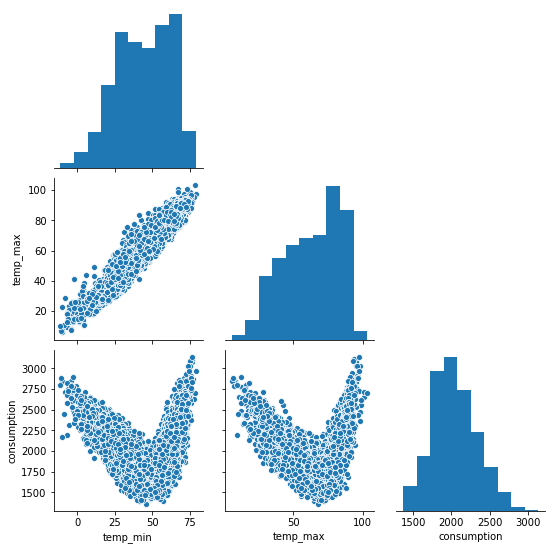

In [12]:
import seaborn as sns
plot_data = dataset.groupby(dataset['datetime'].dt.date).mean()[['temp_min','temp_max','consumption']]
sns.pairplot(plot_data, corner=True);

Looks like there is a curvilinear relationship between the temperature and the power consumption

In [13]:
!pip install holidays
import holidays
us_holidays = holidays.UnitedStates()

In [14]:
# adding business day indication based on weekdays and US holidays
dataset['business_day'] = dataset.datetime.dt.date.apply(lambda x: np.is_busday(x) and x not in us_holidays)

In [15]:
dataset['hour'] = dataset.datetime.dt.hour

In [16]:
dataset.corr()

,temp_min,temp_max,consumption,business_day,hour
temp_min,1.000000,0.954602,-0.013910,0.025636,-0.000150
temp_max,0.954602,1.000000,-0.043023,0.021968,-0.000126
consumption,-0.013910,-0.043023,1.000000,0.347722,0.443914
business_day,0.025636,0.021968,0.347722,1.000000,-0.000301
hour,-0.000150,-0.000126,0.443914,-0.000301,1.000000


There seems to be a correlation between business day / hour and the consumption

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score

numeric_features = ['temp_min','temp_max']
categorical_features = ['business_day','hour']

X = dataset[numeric_features + categorical_features]
y = dataset.consumption
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
# Trying straight-forward linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression() 
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.3319853272543717

In [19]:
scores = cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

326.76844212057824

In [20]:
# adding some preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[('poly',PolynomialFeatures(degree = 2)),
                                      ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

plr = Pipeline([('preprocessor', preprocessor), ('model', LinearRegression())])

In [21]:
%%time
plr.fit(X_train, y_train)
plr.score(X_test, y_test)

CPU times: user 552 ms, sys: 33.4 ms, total: 586 ms
Wall time: 168 ms


0.7186446532521124

In [22]:
scores = cross_val_score(plr, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

214.92124714021423

## Parameter tuning

In [23]:
# Parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

param_grid = {
    'preprocessor__num__poly__degree': range(2,10),
    'model__alpha': [1e-3, 1e-2, 1e-1, 1, 10]}

pipe = Pipeline([('preprocessor', preprocessor), ('model', Ridge())])

grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [24]:
%%time
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)

CPU times: user 2min 7s, sys: 12.1 s, total: 2min 19s
Wall time: 40.1 s


0.7787749838581689

In [25]:
scores = cross_val_score(grid_search, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

191.5039231038041

In [26]:
grid_search.best_params_

{'model__alpha': 0.001, 'preprocessor__num__poly__degree': 9}